In [1]:
from qiskit import *
import numpy as np
import matplotlib.pyplot as plt
from cmath import exp,sin,cos
from qiskit.ignis.mitigation.measurement import (CompleteMeasFitter,complete_meas_cal)
from qiskit.providers.fake_provider import FakeVigo
from qiskit_aer import AerSimulator
# simulator = Aer.get_backend('qasm_simulator')
sim_vigo=AerSimulator.from_backend(FakeVigo())

/tmp/ipykernel_15817/2710918730.py:5: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import (CompleteMeasFitter,complete_meas_cal)


In [2]:
O12=0.58381263
O13=0.1504474
O23=0.7347836
cp_phi=0

In [3]:
mq21=7.5*pow(10,-5)
mq31=2.5*pow(10,-3)
E=1

In [4]:
peq=[]
pmq=[]
puq=[]

for t in range (0,1200,100):
    circ=QuantumCircuit(2,2)
    circ.initialize('10',circ.qubits)
    circ.cx(1,0)
    circ.cu(2*O23,0,0,0,0,1)
    circ.cx(1,0)
    circ.x(0)
    circ.cu(2*O13,cp_phi,-cp_phi,0,0,1)
    circ.x(0)
    circ.x(1)
    circ.cu(2*O12,0,0,0,1,0)
    circ.x(1)
    circ.p(-(2*mq21*1.27*t)/(E),0)
    circ.p(-(2*mq31*1.27*t)/(E),1)
    circ.x(1)
    circ.cu(-2*O12,0,0,0,1,0)
    circ.x(1)
    circ.x(0)
    circ.cu(-2*O13,cp_phi,-cp_phi,0,0,1)
    circ.x(0)
    circ.cx(1,0)
    circ.cu(-2*O23,0,0,0,0,1)
    circ.cx(1,0)
    circ.measure([0,1],[0,1])

    job=sim_vigo.run(transpile(circ,sim_vigo))
    device_results=job.result().get_counts(circ)
    cal_circuits,state_labels=complete_meas_cal(qr=circ.qregs[0],circlabel='measerrormitigationcal')
    cal_job=execute(cal_circuits,backend=sim_vigo,optimization_level=0)
    cal_results=cal_job.result()
    meas_fitter=CompleteMeasFitter(cal_results,state_labels)
    meas_filter=meas_fitter.filter
    mitigated_results=meas_filter.apply(device_results)
    
    total = sum(mitigated_results.values())
    result = {key: value / total for key, value in mitigated_results.items()}
    peq.append(result['00'])
    try:
        pmq.append(result['01'])
    except:
        pmq.append(0)
    try:
        puq.append(result['10'])
    except:
        puq.append(0)



In [5]:
pe=[]
pm=[]
pu=[]
m21=complex(0,7.5*pow(10,-5))
m31=complex(0,2.5*pow(10,-3))

def U(dO,t):
    phi=complex(0,dO)
    H=np.matrix([[1, 0, 0],
                [0, exp(-(2*m21*1.27*t)/(E)), 0],
                [0, 0, exp(-(2*m31*1.27*t)/(E))]])


    U1=np.matrix([[cos(O12)*cos(O13), sin(O12)*cos(O13), sin(O13)*exp(-phi)],
                [-sin(O12)*cos(O23)-cos(O12)*sin(O13)*sin(O23)*exp(phi), cos(O12)*cos(O23)-sin(O12)*sin(O13)*sin(O23)*exp(phi), cos(O13)*sin(O23)],
                [sin(O12)*sin(O23)-cos(O12)*sin(O13)*cos(O23)*exp(phi), -cos(O12)*sin(O23)-sin(O12)*sin(O13)*cos(O23)*exp(phi), cos(O13)*cos(O23)]])

    U1d=U1.getH()
    A=np.matmul(U1,H)
    return(np.matmul(A,U1d))
    
for t in range (0,1200,10):
    state=np.matrix([[0, 0, 0],
                    [0, 0, 0],
                    [0, 0, 1]])

    B=np.matmul(U(cp_phi,t),state)
    fstate=np.matmul(B,U(cp_phi,t).getH())
    pe.append(fstate[0,0])
    pm.append(fstate[1,1])
    pu.append(fstate[2,2])

/home/eldhose/anaconda3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


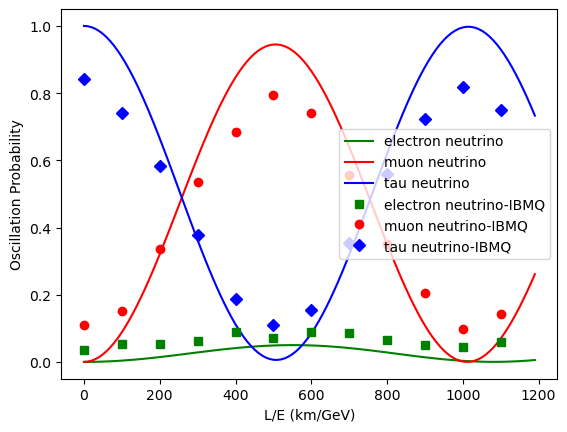

In [6]:
dis=np.arange(0,1200,10)
disq=np.arange(0,1200,100)
plt.plot(dis,pe,color='g',label='electron neutrino')
plt.plot(dis,pm,color='r',label='muon neutrino')
plt.plot(dis,pu,color='b',label='tau neutrino')
plt.plot(disq,peq,color='g',label='electron neutrino-IBMQ',marker='s',linewidth=0,markersize=6)
plt.plot(disq,pmq,color='r',label='muon neutrino-IBMQ',marker='o',linewidth=0,markersize=6)
plt.plot(disq,puq,color='b',label='tau neutrino-IBMQ',marker='D',linewidth=0,markersize=6)
plt.xlabel('L/E (km/GeV)')
plt.ylabel('Oscillation Probability')
plt.legend()
plt.savefig('Tau_vacuum_IBM.jpg')
plt.show()